# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Apply the default theme
sns.set_theme()

readmission = pd.read_csv('/kaggle/input/health-reentry-analysis/readmission_data (1).csv')

In [2]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]

    # Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

print("Readmission Data Summary")
display(check(readmission))
display(readmission.head())

Readmission Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,patient_id,int64,1000,1000,0,0
1,admission_date,object,1000,549,0,0
2,num_diagnoses,int64,1000,10,0,0
3,num_procedures,int64,1000,6,0,0
4,num_external_injuries,int64,1000,4,0,0
5,length_of_stay,int64,1000,30,0,0
6,median_household_income,float64,1000,996,0,0
7,insurance_type,object,1000,3,0,0
8,age,int64,1000,73,0,0
9,gender,object,1000,2,0,0


,patient_id,admission_date,num_diagnoses,num_procedures,num_external_injuries,length_of_stay,median_household_income,insurance_type,age,gender,readmitted,diagnoses,external_injuries,home,facility,homeless,discharge_date
0,3790,2024-06-23 08:04:45.859854,7,0,3,27,37.684,private,62,female,0,Kidney Disease,Electrocution,yes,no,no,2024-07-20 08:04:45.859854
1,2900,2023-08-17 08:04:45.859854,4,3,2,28,31.207,private,60,male,0,COPD,Sprain,yes,yes,no,2023-09-14 08:04:45.859854
2,9648,2023-03-24 08:04:45.859854,8,2,3,27,76.099,private,30,female,0,Liver Disease,Burn,no,no,no,2023-04-20 08:04:45.859854
3,1356,2024-02-11 08:04:45.859854,5,3,0,15,97.496,self-pay,30,female,0,Mental Health,Dislocation,yes,no,no,2024-02-26 08:04:45.859854
4,9989,2023-04-17 08:04:45.859854,7,3,3,11,96.093,public,77,female,0,Cancer,Poisoning,no,no,no,2023-04-28 08:04:45.859854


# Visualization

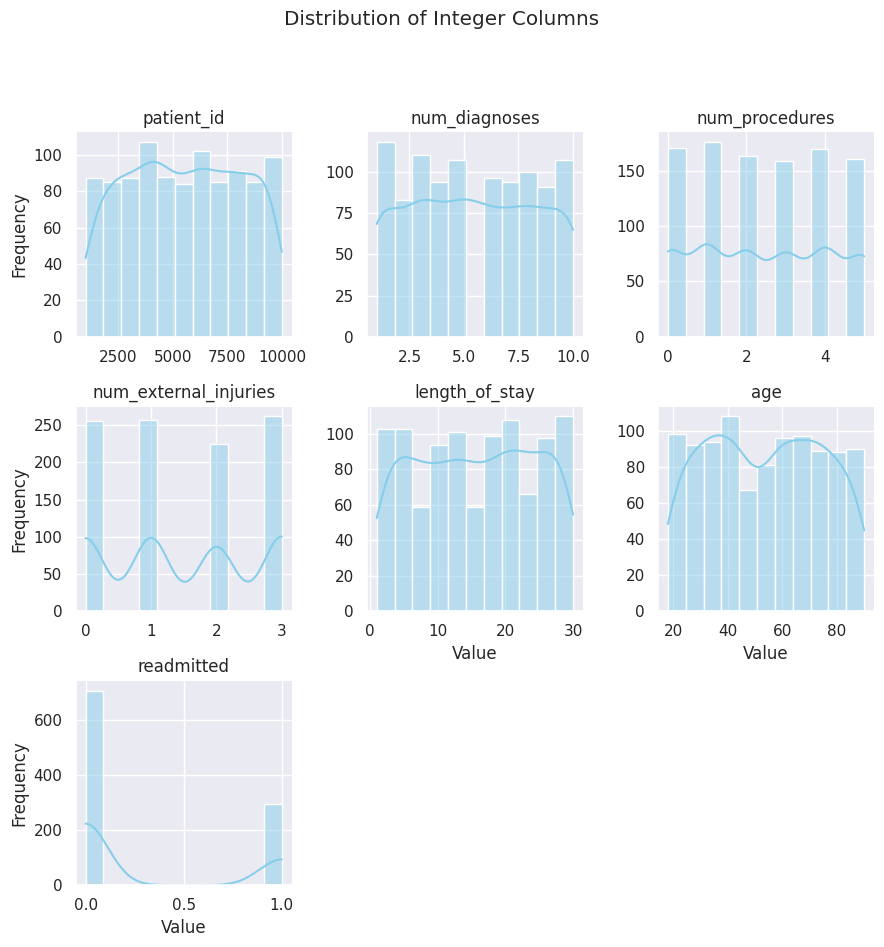

In [3]:
# Select integer columns
int_cols = readmission.select_dtypes(include='int64').columns

# Melt the dataset to use with FacetGrid
melted_data = readmission[int_cols].melt(var_name="Column", value_name="Value")

# Set up the grid
g = sns.FacetGrid(melted_data, col="Column", col_wrap=3, height=3, sharex=False, sharey=False)
g.map(sns.histplot, "Value", kde=True, color="skyblue")

# Adjust layout
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Frequency")
g.fig.suptitle("Distribution of Integer Columns", y=1.05)
plt.tight_layout()
plt.show()

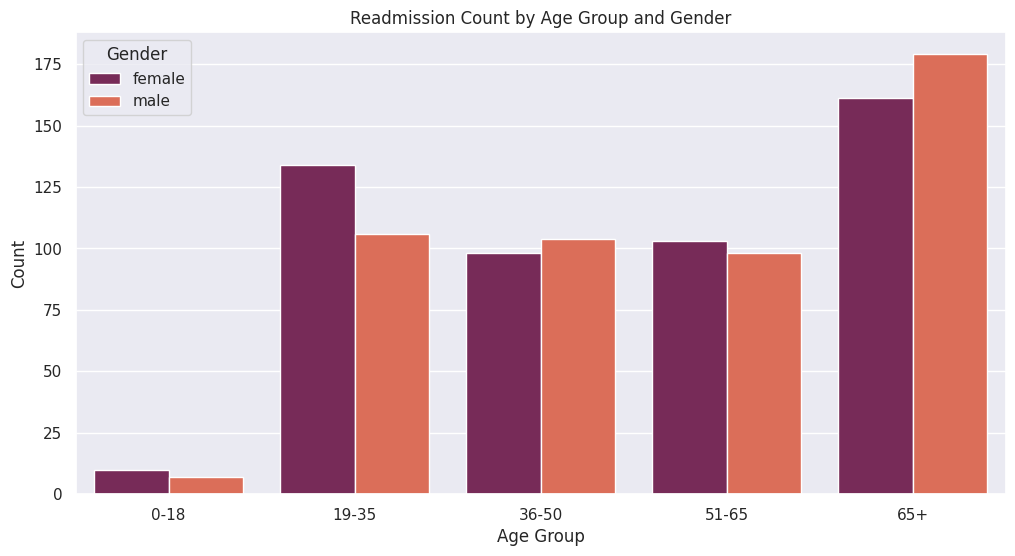

In [4]:
# Age Groups
bins = [0, 18, 35, 50, 65, 100]
labels = ['0-18', '19-35', '36-50', '51-65', '65+']
readmission['age_group'] = pd.cut(readmission['age'], bins=bins, labels=labels)

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(data=readmission, x='age_group', hue='gender', palette="rocket", dodge=True)
plt.title("Readmission Count by Age Group and Gender")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.legend(title="Gender")
plt.show()

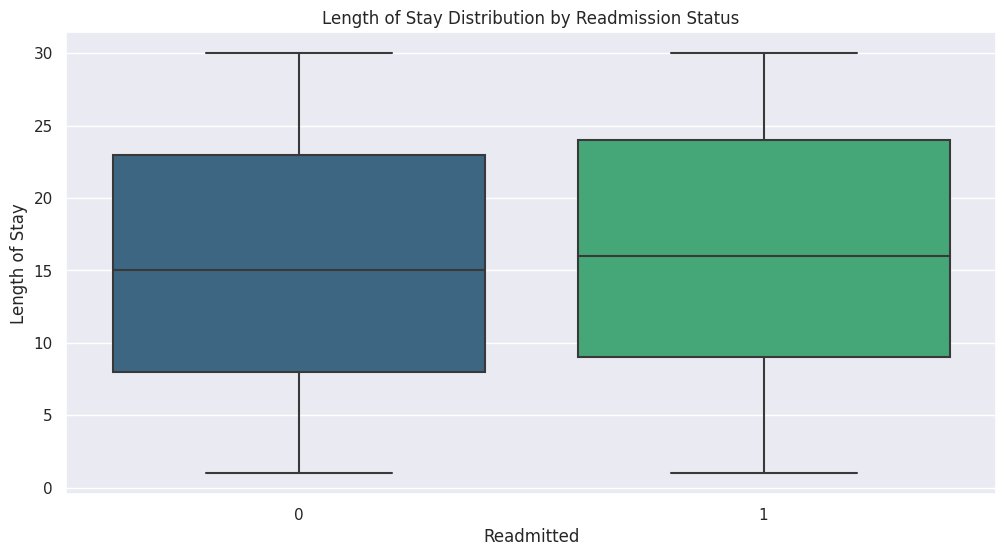

In [5]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=readmission, x='readmitted', y='length_of_stay', palette="viridis")
plt.title("Length of Stay Distribution by Readmission Status")
plt.xlabel("Readmitted")
plt.ylabel("Length of Stay")
plt.show()

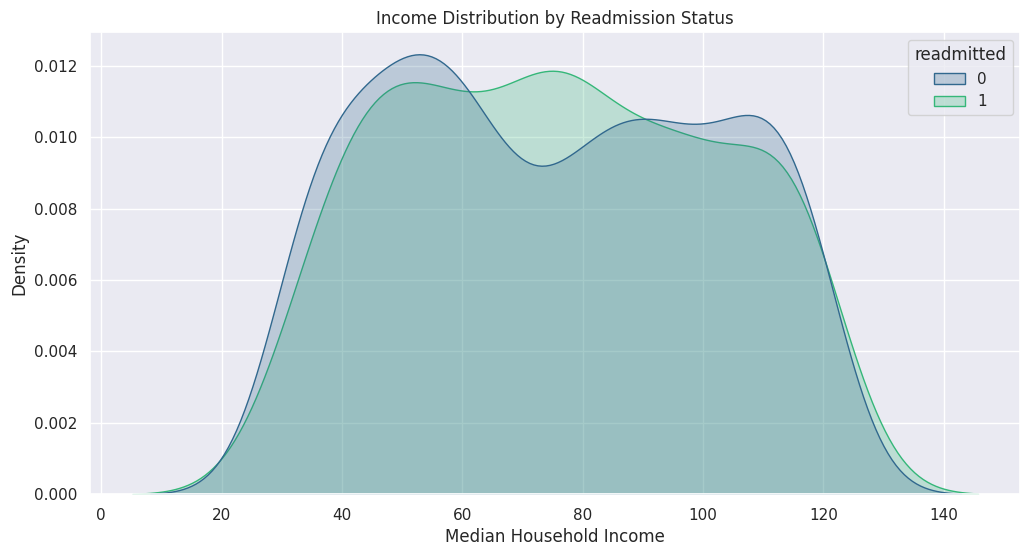

In [6]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=readmission, x='median_household_income', hue='readmitted', fill=True, common_norm=False, palette="viridis")
plt.title("Income Distribution by Readmission Status")
plt.xlabel("Median Household Income")
plt.show()

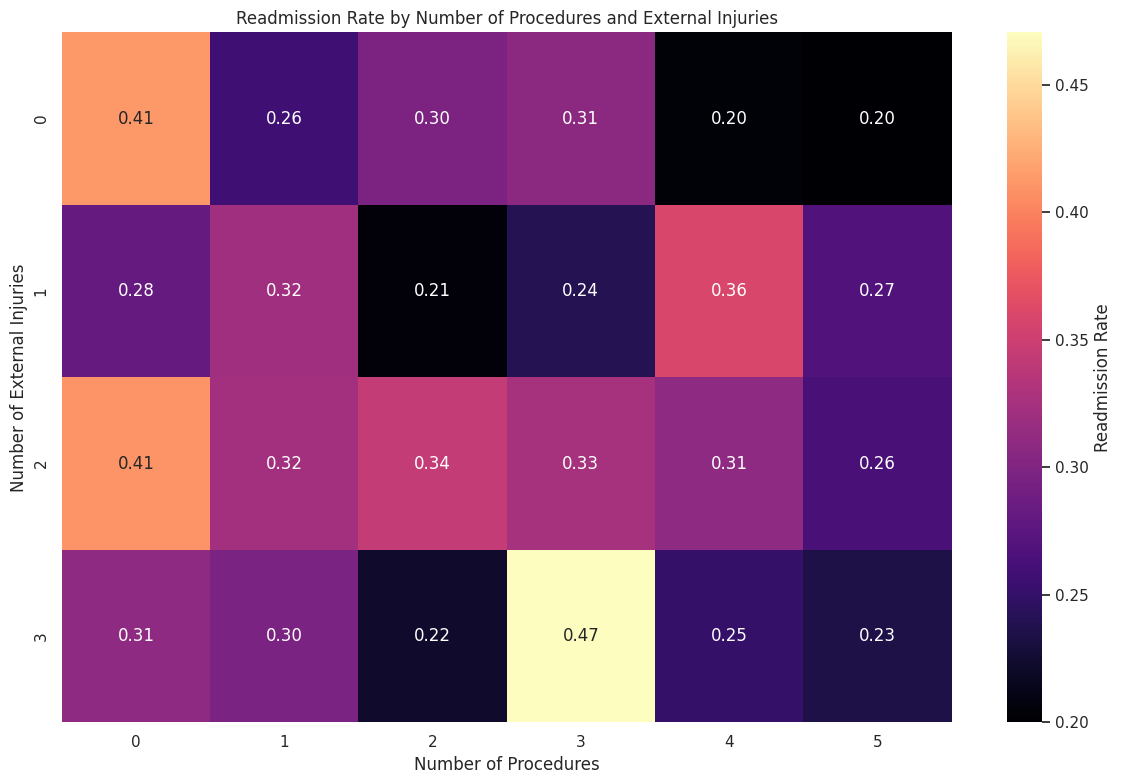

In [7]:
# Create a pivot table to aggregate the data
heatmap_data = readmission.pivot_table(
    values='readmitted',
    index='num_external_injuries',
    columns='num_procedures',
    aggfunc='mean'
)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="magma", annot=True, fmt=".2f", cbar_kws={'label': 'Readmission Rate'})

plt.title("Readmission Rate by Number of Procedures and External Injuries")
plt.xlabel("Number of Procedures")
plt.ylabel("Number of External Injuries")
plt.tight_layout()
plt.show()